# Model Definition 

This asset will be used to define the models that will be used to detect between fraudulent and none fraudelent transaction. Two models will ultimately be used. For the non-deeplearning model we will compare the evaluation scores of 7 different models in order to compare the best of the non-deeplearning versus the deeplearning model. In order to train multiple models quickly and allow computation speed to be within acceptable range we will limit our model to 1,000 fraud samples and 1,000 non-fraud samples.


NOTE: In order to assess the models we will be utilizing confusion matrices then taking the accuracy of our models correctly classifying fraudulent credit card transactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression as LRR
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras import optimizers
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190911163728-0000
KERNEL_ID = 0afa514b-d6ea-4280-ae6c-26299ca8b9bf


Using TensorFlow backend.


## Model I : Non-DeepLearning algorithms

In order to deal with the unbalanced data set and to make our computation times quicker we sample a data set of 1,000 fraud and 1,000 non-fraud cases

In [2]:
# Set seed to have reproducibility
seed =10
np.random.seed(10)

# Set Training Parameters 

TRAIN_SAMPLE = 200000

# Set Validation Size

VALIDATION_SIZE = .2

In [3]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6543831d1aa4422e929557ca99f11127 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='5hFiFZI3uuQ2dZ3KmePOADYRVqx8qVYt0izookom_Ak8',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_6543831d1aa4422e929557ca99f11127.get_object(Bucket='advancedcourseracapstone-donotdelete-pr-evg4tugpydzysx',Key='creditcard.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)



In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
## We scale the only two columns that need to be scaled "Time" and "Column"
scaler = MinMaxScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

#### We must do undersampling and undersampling to prevent two things:
* 1. We do not want to train our model to believe that the probability of classification is skewed to one side or the other. We want the model to be confident that a fraud occurs
* 2. Certain features the "v" columns have seperate correlations to the classification models. Because we have so many more non frauds it makes it very difficult to see any correlations.

In [6]:
non_fraud = df[df['Class'] == 0].sample(350)
fraud = df[df['Class'] == 1].sample(350)

df_350 = non_fraud.append(fraud).reset_index()
X_350 = df_350.drop(['Class'], axis = 1)
X_350 = X_350.drop(["index"],axis =1)
Y_350 = df_350["Class"]

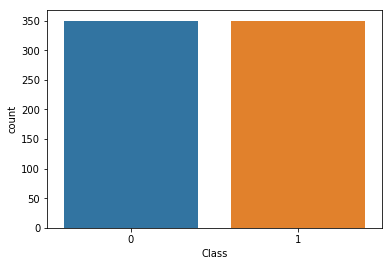

In [7]:
sns.countplot('Class',data =df_350)

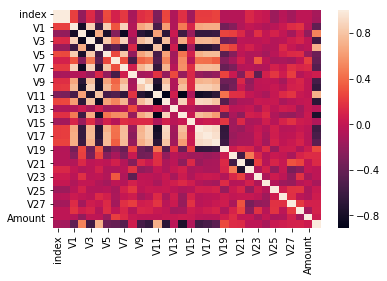

In [8]:
df_350_corr = df_350.corr()
sns.heatmap(df_350_corr)

Here we have a data frame with an equal amount of fraudulent and non-fraudelent cases. This new correlation heatmap demonstrates a much differnt correlation between the variables than the one in the unbalanced set. It will be this which will help train our models. 

### I. Logistic Regression

This is the model definition on a local node as a proof of concept as well as to have a base for how well we want our predictions to be 

In [9]:
lr = LRR()
kfold = model_selection.KFold(n_splits=10,random_state = seed)
x_train_lr,x_test_lr,y_train_lr,y_test_lr = model_selection.train_test_split(X_350,Y_350,test_size = .3, random_state=seed)
lr.fit(x_train_lr,y_train_lr)
prediction_lr = lr.predict(x_test_lr)
report_lr = classification_report(y_test_lr,prediction_lr)
print(report_lr)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       113
           1       0.95      0.90      0.92        97

   micro avg       0.93      0.93      0.93       210
   macro avg       0.93      0.93      0.93       210
weighted avg       0.93      0.93      0.93       210



/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
test_df_x  = df.drop("Class",axis = 1)
test_df_y  = df["Class"]

In [11]:
prediction_true=lr.predict(test_df_x)
report_lr_true = classification_report(test_df_y,prediction_true)
print(report_lr_true)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    284315
           1       0.03      0.93      0.07       492

   micro avg       0.95      0.95      0.95    284807
   macro avg       0.52      0.94      0.52    284807
weighted avg       1.00      0.95      0.97    284807



Confusion Matrix

Text(33.0, 0.5, 'True Label')

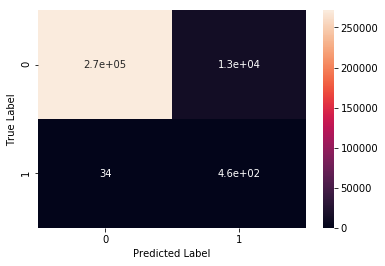

In [12]:
results = confusion_matrix(test_df_y, prediction_true)

sns.heatmap(results,annot =True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

Our local model did pretty well with an f1score of 93% detecting most of the fraudulent credit card transactions.

### Logistic Regression With Spark

Now we will implement the model on Apache Spark in order to run all of our machine learning on the cloud.

In [13]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-8a08c4e8-e805-421a-9b5a-8d8b1b3b4d78',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': '5hFiFZI3uuQ2dZ3KmePOADYRVqx8qVYt0izookom_Ak8'
}

configuration_name = 'os_6543831d1aa4422e929557ca99f11127_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_spark = spark.read.parquet(cos.url('df_engin_label.parquet', 'advancedcourseracapstone-donotdelete-pr-evg4tugpydzysx'))


NOTE: A pipeline that has created a normalized features vector column has already been applied to this datafram 'df_engin.parquet'. This can be seen 'credit_card_fraud.feat_eng.jupyter.v1'.

In [14]:
df_spark.show()

+-----+--------------------+--------------------+
|label|            features|       features_norm|
+-----+--------------------+--------------------+
|    0|[0.0,-1.359807133...|[0.0,-0.008352305...|
|    0|[0.0,1.1918571113...|[0.0,0.0990160021...|
|    0|[1.0,-1.358354061...|[0.00247767129574...|
|    0|[1.0,-0.966271711...|[0.00708831461517...|
|    0|[2.0,-1.158233093...|[0.02296611443072...|
|    0|[2.0,-0.425965884...|[0.12744239703997...|
|    0|[4.0,1.2296576345...|[0.21045578224598...|
|    0|[7.0,-0.644269442...|[0.09609968216933...|
|    0|[7.0,-0.894286082...|[0.06055060797294...|
|    0|[9.0,-0.338261752...|[0.34989303344852...|
|    0|[10.0,1.449043781...|[0.27866855142573...|
|    0|[10.0,0.384978215...|[0.27152489312668...|
|    0|[10.0,1.249998742...|[0.06667393065300...|
|    0|[11.0,1.069373587...|[0.21923935251122...|
|    0|[12.0,-2.79185476...|[0.12794986433141...|
|    0|[12.0,-0.75241704...|[0.26031125157463...|
|    0|[12.0,1.103215435...|[0.32245660558223...|


We split the data into 70% training data and 30% test data.

### Train/Validate/Split

In [15]:
splits = df_spark.randomSplit((0.7,0.3))
df_spark_train = splits[0]
df_spark_test = splits[1]

### Model Definition

In [16]:
lr_spark= LogisticRegression(featuresCol='features_norm', labelCol='label',maxIter = 10)

### Model Training

In [17]:
model_lr_spark = lr_spark.fit(df_spark_train)
prediction_lr_spark = model_lr_spark.transform(df_spark_train)
prediction_lr_spark.show()

+-----+--------------------+--------------------+--------------------+--------------------+----------+
|label|            features|       features_norm|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    0|[0.0,1.1918571113...|[0.0,0.0990160021...|[170.673706887158...|[1.0,7.5396449148...|       0.0|
|    0|[1.0,-1.358354061...|[0.00247767129574...|[16.1262024415517...|[0.99999990080741...|       0.0|
|    0|[1.0,-0.966271711...|[0.00708831461517...|[23.0417136055868...|[0.99999999990157...|       0.0|
|    0|[2.0,-0.425965884...|[0.12744239703997...|[134.504669192521...|[1.0,3.8491459561...|       0.0|
|    0|[4.0,1.2296576345...|[0.21045578224598...|[3.86692669857000...|[0.97950621069575...|       0.0|
|    0|[7.0,-0.894286082...|[0.06055060797294...|[7.76841064051664...|[0.99957729390698...|       0.0|
|    0|[7.0,-0.644269442...|[0.09609968216933...|[27.9477095688214...|[0.

### Model Evaluation

In [18]:
evaluator_lr_spark = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr_spark = evaluator_lr_spark.evaluate(prediction_lr_spark)
print("Test Error = %g" % (1.0 - accuracy_lr_spark))

Test Error = 0.00156738


In [19]:
model_lr_spark.summary

In [20]:
evaluator_lr_spark_bin = BinaryClassificationEvaluator()
evaluator_lr_spark_bin.evaluate(prediction_lr_spark)

0.9301408694672376

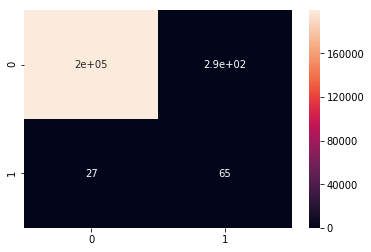

In [21]:
x_lr_spark= prediction_lr_spark.select("prediction").toPandas()
y_lr_spark =prediction_lr_spark.select("label").toPandas()
results_lr_spark=confusion_matrix(x_lr_spark,y_lr_spark)
sns.heatmap(results_lr_spark,annot =True)

## Model II : DeepLearning Algorithm using Keras, Autoencoder 


We first import the dataframe from the csv file. 

In [22]:

body = client_6543831d1aa4422e929557ca99f11127.get_object(Bucket='advancedcourseracapstone-donotdelete-pr-evg4tugpydzysx',Key='creditcard.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_ai= pd.read_csv(body)
df_ai.describe()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Cleaning the DataSet

In [23]:
df_ai.columns = map(str.lower, df_ai.columns)
df_ai.rename(columns={'class': 'label'}, inplace=True)
df_ai['log10_amount'] = np.log10(df_ai.amount + 0.00001)
# print first 5 rows to get an initial impression of the data we're dealing with
df_ai.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v22,v23,v24,v25,v26,v27,v28,amount,label,log10_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,2.174990
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.429754
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2.578249
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,2.091667
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.845036


In order to implement the autencoder algorithm we will have two models. One to dearng the weights for the appopriate latent representation of the weights and then a classifier to predict wheter a given transaction is a fraud or not a fraud. 

We first seperate the dataset into a train set and a test set.

In [24]:
# For Observation of Data Define SubSample of Data

FRAUD_RATIO = 10

# NOTE: the effects of TIME and AMOUNT on the Transaction our Negligible

df_ai = df_ai.drop(["time","amount"], axis =1)
fraud_df = df_ai[df_ai.label ==1]
clean_df = df_ai[df_ai.label ==0]
clean_df.shape

(284315, 30)

In [25]:
clean_Undersampled_df = clean_df.sample(int(len(fraud_df)*FRAUD_RATIO),random_state = seed)
visual = pd.concat([fraud_df,clean_Undersampled_df])
column_Names = list(visual.drop('label',axis=1).columns)
features, labels = visual.drop('label', axis=1).values, \
                   visual.label.values

In [26]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('Error')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=seed).fit_transform(features)
    
   
    fig, ax = plt.subplots(figsize=(8,8))
    
    
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

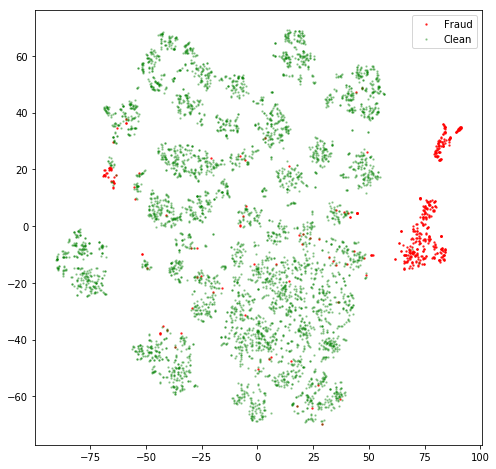

In [27]:
tsne_scatter(features,labels,dimensions=2,save_as = 'tsne_initial.png')

Here we can see that we can seperate the fraudulent cases from the non fradulent cases in the undersampled dataset.

### Train/Validate/Split

For the encoder to work we will train, test, and validate our data in the following way

1. Training

    A. Actual Training of Our Encoder 
    
    B. Validation of Neural Network (Generalization)
2. Testing: Mix of fraud and non-fraud

    A. Apply Threshold

In [28]:
clean_df.shape

(284315, 30)

In [29]:
fraud_df.shape

(492, 30)

In [30]:
# SHUFFLING TRAIN SET

clean_df = clean_df.sample(frac=1).reset_index(drop=True)

# TRAIN_SET ONLY NON_FRAUD TRANSACTIONS

X_train = clean_df.iloc[:TRAIN_SAMPLE].drop('label', axis=1)

# TESTING SET INCLUDING MIX OF TRANSACTIONS

X_test = clean_df.iloc[TRAIN_SAMPLE:].append(fraud_df).sample(frac=1)

# SPLITTING THE DATA

X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATION_SIZE, 
                                       random_state=seed)




X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values


### Normalizing and Scaling Pipeline

In [31]:
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [32]:
pipeline.fit(X_train)
X_train_tran = pipeline.transform(X_train)
X_validate_tran = pipeline.transform(X_validate)

### Model Definition With Keras

In [33]:
#DEFINE PARAMETERS

INPUT_DIM = X_train_tran.shape[1]
LATENT_DIM = 2
BATCH_SIZE = 256
EPOCHS = 30

In [34]:
# DEFINE THE MODEL

autoencoder = Sequential()
autoencoder.add(Dense(INPUT_DIM,activation ='elu',input_shape=(INPUT_DIM,)))
autoencoder.add(Dense(LATENT_DIM, activation = 'elu'))
autoencoder.add(Dense(INPUT_DIM, activation = 'elu'))

autoencoder.compile(optimizer = 'adam',loss='mse',metrics=['acc'])

autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 60        
_________________________________________________________________
dense_3 (Dense)              (None, 29)                87        
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [35]:

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr_hist_ai = LossHistory()



In [36]:
model = autoencoder.fit(X_train_tran,X_train_tran,
                        epochs= EPOCHS,
                        callbacks=[lr_hist_ai],
                        batch_size = BATCH_SIZE, 
                        shuffle=True,
                        validation_data = (X_validate_tran, X_validate_tran))

Instructions for updating:
Use tf.cast instead.


Train on 160000 samples, validate on 40000 samples
Epoch 1/30
160000/160000 [==============================] - 3s 17us/step - loss: 0.0518 - acc: 0.1552 - val_loss: 0.0162 - val_acc: 0.2546427516, 0.26412353, 0.25531086, 0.25500122, 0.251446, 0.24783385,0.24925062, 0.24323548, 0.24278164, 0.23842005, 0.23606582, 0.23270917, 0.23390216, 0.22932252, 0.22568414, 0.2286346, 0.22650833, 0.227192790.22543633, 0.22424214, 0.22204623, 0.22077113, 0.21971239, 0.21714309, 0.21646947, 0.213676, 0.21203548, 0.21194577, 0.20944983, 0.209753, 0.207596870.20493375, 0.20487623, 0.2023677, 0.20044881, 0.19908577, 0.20162386, 0.19783819, 0.19587907, 0.19613558, 0.19250163, 0.19264007, 0.19283491, 0.190203040.18851969, 0.18709189, 0.18336305, 0.18353803, 0.18339175, 0.18120125, 0.18103558, 0.1783286, 0.17789024, 0.17698494, 0.17669266, 0.17377608, 0.17184636, 0.17332312, 0.17065907, 0.17030269, 0.16985045, 0.16609944, 0.166347240.16506135, 0.16214389, 0.16025078, 0.16008052, 0.15977792, 0.15757358, 0.158

160000/160000 [==============================] - 2s 11us/step - loss: 0.0160 - acc: 0.2529 - val_loss: 0.0159 - val_acc: 0.25455931137, 0.0160157, 0.016108423, 0.016280247, 0.016083006, 0.016073871, 0.016172286, 0.016223527, 0.01641591, 0.016121034, 0.016037911, 0.016163092, 0.015809983, 0.016021285, 0.01609419, 0.01639691, 0.015987441, 0.016022723,0.016222473, 0.016063618, 0.015916925, 0.015960686, 0.016095482, 0.01628847, 0.01587541, 0.016088832, 0.016024847, 0.016499506, 0.01594998, 0.016237808, 0.016010799, 0.015971923, 0.016150896, 0.01623008, 0.016106948, 0.0162189, 0.016013062, 0.015994415, 0.015948046,0.015741333, 0.016037844, 0.016048403, 0.016031088, 0.01591956, 0.01574317, 0.015847398, 0.01621648, 0.016183358, 0.016177142, 0.016054131, 0.016041063, 0.01607984, 0.015976544, 0.016326869, 0.016058696, 0.016080275, 0.01587968, 0.016038004, 0.01617625, 0.016070124,0.015984371, 0.016067952, 0.016108856, 0.016028656, 0.015993569, 0.016004058, 0.015924253, 0.016135724, 0.0161359, 0.

160000/160000 [==============================] - 2s 12us/step - loss: 0.0156 - acc: 0.2529 - val_loss: 0.0155 - val_acc: 0.2546015902793, 0.015535579, 0.015455199, 0.015801698, 0.015894286, 0.016101645, 0.015668165, 0.015819324, 0.015803987, 0.01575627, 0.01568383, 0.015496548, 0.015535458, 0.015847167, 0.015424065, 0.015357305, 0.015987862,0.015648093, 0.015841924, 0.015687801, 0.015505635, 0.01583992, 0.01606544, 0.01575848, 0.015651315, 0.015598013, 0.015616915, 0.015968522, 0.015800232, 0.015829712, 0.01580924, 0.015674489, 0.015878946, 0.016060056, 0.015950602, 0.015471623, 0.0157706,0.01573655, 0.015580632, 0.015828637, 0.015455884, 0.015688127, 0.01594735, 0.01573705, 0.015708778, 0.015658028, 0.015905585, 0.01572959, 0.015523933, 0.015831422, 0.015780784, 0.015658919, 0.015653351, 0.015373926, 0.015361869, 0.015475182, 0.01595588, 0.015671574,0.0154682305, 0.01553371, 0.015980253, 0.015632322, 0.01596197, 0.015697002, 0.015805217, 0.015595058, 0.01553893, 0.015771473, 0.0156070

160000/160000 [==============================] - 2s 11us/step - loss: 0.0149 - acc: 0.2735 - val_loss: 0.0147 - val_acc: 0.28665126872, 0.015396438, 0.014780847, 0.014916144, 0.015142896, 0.014958175, 0.015370918, 0.014945071, 0.014902547, 0.014973858, 0.015292248, 0.01488455, 0.015099677, 0.015405637, 0.015254465, 0.015164261, 0.014662498, 0.014800587,0.015059374, 0.014950187, 0.015026529, 0.015124712, 0.015044378, 0.014852948, 0.015287027, 0.015211942, 0.014972815, 0.015203545, 0.015057372, 0.014644425, 0.014992069, 0.0150641985,0.015130399, 0.015139112, 0.015173643, 0.015059888, 0.014974153, 0.015079271, 0.014955241, 0.014866928, 0.014694975, 0.015147733, 0.014934957, 0.0149573125, 0.015149729, 0.015469357, 0.015177488, 0.0150349345, 0.015056364, 0.014631617, 0.015009891, 0.014841165, 0.014582435,0.015098562, 0.015200014, 0.015223011, 0.015391138, 0.014789498, 0.014935705, 0.014852075, 0.014883118, 0.014938518, 0.014964935, 0.014784238, 0.014754547, 0.014999861, 0.015006323, 0.01492

160000/160000 [==============================] - 2s 11us/step - loss: 0.0142 - acc: 0.3244 - val_loss: 0.0141 - val_acc: 0.3348014461615, 0.014468913, 0.014048411, 0.01432151, 0.01454235, 0.014778255, 0.0144974645, 0.014377763, 0.0145514365, 0.014223633, 0.013907384, 0.014319977, 0.014417901, 0.014391106, 0.014258908, 0.014209855,0.0142696975, 0.014254262, 0.014715097, 0.014343315, 0.014577944, 0.014075039, 0.01418763, 0.014206165, 0.014352007, 0.014400451, 0.014664327, 0.014162684, 0.01423401, 0.014216255, 0.013766278, 0.014492195, 0.0142733725, 0.014156332, 0.014200336,0.0144252945, 0.014304575, 0.014211226, 0.014413384, 0.014379698, 0.014539091, 0.014329349, 0.014395272, 0.014253585, 0.014079128, 0.014233958, 0.014254492, 0.014469031, 0.014399036, 0.014156571, 0.01439321, 0.0143847065, 0.0142966695, 0.014348442, 0.014089965,0.01428666, 0.014292349, 0.014240923, 0.014260022, 0.0141400425, 0.014141034, 0.014135028, 0.0139598185, 0.014419664, 0.014291869, 0.014484227,0.014303579, 0.014

160000/160000 [==============================] - 2s 11us/step - loss: 0.0139 - acc: 0.3383 - val_loss: 0.0139 - val_acc: 0.34973868104, 0.014182713, 0.013901589, 0.013692575, 0.013941595, 0.013942331, 0.01401969, 0.013916131, 0.013716081, 0.01422129, 0.014075536, 0.013899938, 0.014172463, 0.013774403, 0.013787951, 0.0141094625, 0.0139208045,0.014066095, 0.013974397, 0.014014676, 0.013714395, 0.014144457, 0.014291235, 0.014210554, 0.013875982, 0.014396067, 0.013769837, 0.013887716, 0.013905494, 0.013706097, 0.014119411, 0.013843568, 0.013952249, 0.013917503, 0.01398607,0.014072165, 0.014009476, 0.0140077025, 0.014184957, 0.014299858, 0.014135158, 0.01406054, 0.013863843, 0.014116174, 0.01426102, 0.013734769, 0.013508672, 0.013919185, 0.013699452, 0.014067374, 0.014085088, 0.013956468, 0.013867585, 0.014009593, 0.01410184, 0.013950733,0.013765567, 0.013962326, 0.014010815, 0.014089633, 0.013722467, 0.014020328, 0.014046794, 0.013594765, 0.014107244, 0.014118835, 0.013961696, 0.014184976,

160000/160000 [==============================] - 2s 11us/step - loss: 0.0138 - acc: 0.3363 - val_loss: 0.0138 - val_acc: 0.34223739683, 0.013479765, 0.013897646, 0.014035756, 0.01386776, 0.01382864, 0.013665287, 0.01331078, 0.014131801, 0.013841853, 0.013975088, 0.013996725, 0.01396971, 0.013823741, 0.013813148, 0.01374631, 0.014106609, 0.01411632, 0.0138583705,0.013554517, 0.013757287, 0.0138172675, 0.014009004, 0.013774968, 0.013640793, 0.01377712, 0.013994524, 0.013951158, 0.0139728915, 0.013704006, 0.013857018, 0.013556989, 0.014089232, 0.013758309, 0.013891492, 0.0136251915, 0.013826984, 0.013495393, 0.013698496, 0.014074497,0.0140123535, 0.013957053, 0.013811737, 0.013839398, 0.013523474, 0.01397411, 0.013523797, 0.0138724325, 0.013419744, 0.013396472, 0.013867673, 0.013565439, 0.01402509, 0.013625778, 0.013846283, 0.013792761, 0.0138073955, 0.013986943, 0.013703594, 0.01388227, 0.013608487, 0.0140558705,0.01400969, 0.013894429, 0.013443529, 0.013762462, 0.013967499, 0.013995435,

160000/160000 [==============================] - 2s 11us/step - loss: 0.0137 - acc: 0.3351 - val_loss: 0.0137 - val_acc: 0.339413814479, 0.013251225, 0.014009948, 0.013643963, 0.013698958, 0.013685604, 0.013648591, 0.013501862, 0.013454439, 0.0139504485, 0.013708072, 0.013943456, 0.013906011, 0.013488956, 0.0137588065,0.013620144, 0.013622981, 0.013515951, 0.0133807715, 0.013690399, 0.013196919, 0.013741763, 0.013583733, 0.013901282, 0.013920685, 0.013484796, 0.013637909, 0.013805833, 0.013813617, 0.013717709, 0.013415843, 0.013506794, 0.013768168, 0.013940222, 0.013528485, 0.013912669,0.013608081, 0.013584362, 0.013682579, 0.013762448, 0.013691444, 0.01364336, 0.014005881, 0.013984345, 0.013653093, 0.0135825435, 0.013921803, 0.013611865, 0.013506951, 0.0138847325, 0.013656842, 0.013724677, 0.013841554, 0.013613936, 0.013867255, 0.013649421, 0.013922009,0.0134305665, 0.01394217, 0.013658905, 0.014167261, 0.013647442, 0.013616886, 0.013525723, 0.013376379, 0.01358166, 0.013543334, 0.013

160000/160000 [==============================] - 2s 12us/step - loss: 0.0137 - acc: 0.3354 - val_loss: 0.0137 - val_acc: 0.34313791922, 0.013981685, 0.0137166185, 0.013681136, 0.014000561, 0.0137001695, 0.013617735, 0.013689928, 0.013706662, 0.01356834, 0.013435247, 0.013748849, 0.013708873, 0.013586464, 0.013623453, 0.013609476, 0.013677251,0.0136431735, 0.01384921, 0.013476489, 0.01353124, 0.014167646, 0.013434677, 0.013433647, 0.013582826, 0.013555632, 0.013324235, 0.01351538, 0.013565457, 0.013887059, 0.013705723, 0.013755442, 0.013833361, 0.0136376405, 0.013616699, 0.013488295,0.01386163, 0.013484402, 0.013965527, 0.013666622, 0.013540426, 0.013615426, 0.013529132, 0.013707405, 0.01341654, 0.013770405, 0.013925636, 0.013902152, 0.014066022, 0.013905728, 0.013841145, 0.01355147, 0.013241237, 0.013714927, 0.013962068, 0.01342804,0.013665807, 0.013900898, 0.014015146, 0.014010048, 0.01355394, 0.013668232, 0.01360169, 0.013448892, 0.013756523, 0.013664788, 0.013263494, 0.014014211, 0.

160000/160000 [==============================] - 2s 12us/step - loss: 0.0137 - acc: 0.3370 - val_loss: 0.0137 - val_acc: 0.34373458334, 0.013455463, 0.013085021, 0.013739875, 0.013615785, 0.014044109, 0.013836944, 0.013671091, 0.013290191, 0.014039322, 0.013562924, 0.01357994, 0.013756608, 0.013682917, 0.013935791, 0.013793009, 0.013656372,0.013826355, 0.014043468, 0.014039745, 0.013720771, 0.013805275, 0.013372351, 0.013510147, 0.014021264, 0.013842731, 0.013804799, 0.013673723, 0.013751807, 0.01410852, 0.0137497, 0.013593312, 0.014150102, 0.013809445, 0.014135448, 0.013571304, 0.013534664,0.013331491, 0.0137782525, 0.013528688, 0.013791682, 0.013876289, 0.013671803, 0.013857143, 0.013628356, 0.0138246175, 0.013547739, 0.013621714, 0.013693837, 0.013552632, 0.013625993, 0.013474677, 0.013522945, 0.013669501, 0.01342633, 0.013829444,0.013839963, 0.013711568, 0.013506725, 0.013750642, 0.013301246, 0.013294516, 0.013628563, 0.0134704225, 0.013561243, 0.013519212, 0.013709279, 0.013358956

160000/160000 [==============================] - 2s 12us/step - loss: 0.0136 - acc: 0.3381 - val_loss: 0.0137 - val_acc: 0.3428013526974, 0.01321041, 0.013650758, 0.013382022, 0.0135138575, 0.013270266, 0.013563753, 0.013725364, 0.013322068, 0.013753442, 0.013473213, 0.013759602, 0.013273205, 0.013572179, 0.013618754, 0.013557319, 0.01349068, 0.013612414, 0.013563041,0.013315243, 0.013806321, 0.013830394, 0.013651695, 0.013044616, 0.013579682, 0.013685008, 0.013537301, 0.013878111, 0.013704019, 0.013451992, 0.013783409, 0.013350827, 0.013491016, 0.013498362, 0.0134664755, 0.014024559, 0.013681114, 0.01383891, 0.013606412, 0.013913322,0.013695673, 0.013634678, 0.013661527, 0.0134139275, 0.013648233, 0.013474116, 0.013761449, 0.013147942, 0.013619533, 0.013570158, 0.013727248, 0.01340973, 0.013417959, 0.013711021, 0.013697477, 0.013743378, 0.013749365, 0.013763049, 0.014192179, 0.01378384, 0.014143443,0.013801248, 0.013611559, 0.013689939, 0.013473563, 0.013928976, 0.013838749, 0.0130890

160000/160000 [==============================] - 2s 13us/step - loss: 0.0136 - acc: 0.3393 - val_loss: 0.0137 - val_acc: 0.340713385135, 0.013679224, 0.013537618, 0.013411306, 0.013290038, 0.013541616, 0.013527984, 0.0137393465, 0.013587596, 0.013280948, 0.013501138, 0.013709625, 0.01367292, 0.013569884, 0.014144179,0.013757452, 0.013609501, 0.013437463, 0.013570885, 0.013446791, 0.013702144,0.013851368, 0.013758671, 0.014190307, 0.013677069, 0.013703286, 0.013815679, 0.01359146, 0.013380038, 0.013522804, 0.013668341, 0.013596399,0.014251146, 0.013538447, 0.013472166, 0.013539395, 0.013599853, 0.013732718, 0.013772376, 0.013883294, 0.0137769375, 0.0136523675, 0.013792485, 0.012998527, 0.013775481, 0.013630752,0.013259107, 0.01351917, 0.013824547, 0.013721775, 0.013879498, 0.013791495, 0.013841639, 0.013748027, 0.013358928, 0.013349843, 0.014019286, 0.013342912, 0.013681275,0.0134613, 0.013383606, 0.013588434, 0.013633155, 0.013649738, 0.0135531295, 0.013770556, 0.013519166, 0.013381599

160000/160000 [==============================] - 2s 12us/step - loss: 0.0136 - acc: 0.3410 - val_loss: 0.0136 - val_acc: 0.3453013520069, 0.013452215, 0.013773919, 0.013489589, 0.01379054, 0.013654454, 0.013393596, 0.013738925, 0.0133497305, 0.0136597445, 0.013578967, 0.013593577, 0.013569736, 0.013302384,0.013337845, 0.013845808, 0.013597824, 0.013821126, 0.013856996, 0.013670152, 0.013488425, 0.013416173, 0.013703961, 0.013344683, 0.013533387, 0.01326284, 0.013669898, 0.013752133, 0.013757516, 0.013605552, 0.01341611,0.013565547, 0.013732409, 0.013539422, 0.013569409, 0.013733624, 0.01378081, 0.013616396, 0.013985015, 0.013641024, 0.01380475, 0.013664544, 0.013611751, 0.013754914, 0.013877523, 0.013680996, 0.013489872, 0.013485102, 0.013484713, 0.013790812,0.01349586, 0.013189276, 0.013639061, 0.013535044, 0.013725366, 0.013577799, 0.013493305, 0.013422791, 0.013486054, 0.013452898, 0.013616569, 0.013952467, 0.013488534, 0.0136103155, 0.013523842, 0.013862465, 0.01370641, 0.013852816

160000/160000 [==============================] - 2s 12us/step - loss: 0.0136 - acc: 0.3430 - val_loss: 0.0136 - val_acc: 0.34793915127, 0.01371533, 0.013683716, 0.013785743, 0.013462724, 0.013654187, 0.013649286, 0.013660131, 0.013720004, 0.013162751, 0.013531371, 0.013553546, 0.013602076, 0.013526253, 0.013841514, 0.013527282, 0.013594734,0.013800834, 0.013731023, 0.013411086, 0.013614115, 0.013707653, 0.013205407, 0.013481053, 0.013623564, 0.013632742, 0.01391027, 0.013609533, 0.0133493235, 0.013523996, 0.013212282, 0.014213613, 0.013526323, 0.013788177, 0.013411696, 0.013761003,0.013285545, 0.01363652, 0.013471808, 0.01349321, 0.0134573225, 0.014131209, 0.0135875875, 0.013746161, 0.013620831, 0.013291702, 0.01368, 0.01392098, 0.013704125, 0.013549769, 0.01379964, 0.013722427, 0.013536517, 0.013481063, 0.01347092, 0.013577772,0.013634342, 0.013475498, 0.013426846, 0.013711015, 0.013541972, 0.013821632, 0.013514947, 0.013216481, 0.013954688, 0.01349711, 0.013420781, 0.01305595, 0.0135

160000/160000 [==============================] - 2s 11us/step - loss: 0.0136 - acc: 0.3452 - val_loss: 0.0136 - val_acc: 0.34831397507, 0.013636542, 0.013555971, 0.013478979, 0.013534213, 0.01371544, 0.013936382, 0.013596123, 0.013502493, 0.01346878, 0.013214601, 0.013307288, 0.0134206675, 0.013621375, 0.013706798, 0.013886675, 0.013407623, 0.01324159,0.01365366, 0.013773559, 0.01332992, 0.013809243, 0.01377474, 0.013318744, 0.01376685, 0.013374431, 0.013749799, 0.013761438, 0.01390589, 0.013508498, 0.013947612, 0.0136492625, 0.013731794, 0.013693497, 0.0138138775, 0.013657667, 0.01355442, 0.013705479, 0.013362667,0.014151741, 0.014051849, 0.013745233, 0.013592223, 0.0137353735, 0.013709559, 0.013560633, 0.0134255765, 0.013795644, 0.013813178, 0.013926096, 0.01388565, 0.013469365, 0.0135607915, 0.013481006, 0.013736056, 0.0136345215, 0.013484368,0.013907855, 0.013665559, 0.013326686, 0.013772503, 0.013470909, 0.013799069, 0.013405719, 0.013879368, 0.013231807, 0.013982162, 0.013571661,

In [38]:
X_test_tran = pipeline.transform(X_test)


reconstructions = autoencoder.predict(X_test_tran)

### Model Evaluation

In [39]:
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
def detect_mad_outliers(points, threshold=3.5):  
    
   
    median = np.median(points, axis=0)
    deviation = np.abs(points - median)
    med_abs_deviation = np.median(deviation)
    modified_z_score = 0.6745 * deviation / med_abs_deviation
    
    idx = (np.abs(modified_z_score - threshold)).argmin()
    threshold_value = points[idx]

    return modified_z_score, threshold_value


Z_SCORE= 3

# find the outliers on our reconstructions' mean squared errors
mad_z_scores, threshold_value = detect_mad_outliers(mse, threshold=Z_SCORE)
mad_outliers = (mad_z_scores > Z_SCORE).astype(int)
anomalies = len(mad_outliers[mad_outliers==True])
total_trades = len(y_test)

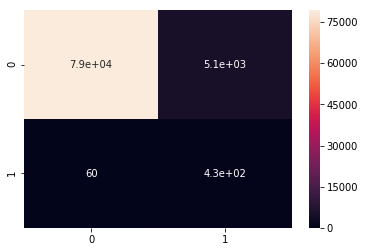

In [40]:
cm = confusion_matrix(y_test, mad_outliers)

sns.heatmap(cm,annot =True)

In [46]:
cm[1][1]/(cm[1][0] + cm[1][1])

0.8780487804878049

## Results

Now we have the results of both the logistic regression on as a spark job and the autoencoder.

In [49]:
print("The accuracy of the of the autoencoder in detecting the fraudulent credit cards: %.2f" %(cm[1][1]/(cm[1][0] + cm[1][1])))
print("The accuracy of the of the logistic regression in detecting the fraudulent credit cards: %.2f" %(results[1][1]/(results[1][0] + results[1][1])))

The accuracy of the of the autoencoder in detecting the fraudulent credit cards: 0.88
The accuracy of the of the logistic regression in detecting the fraudulent credit cards: 0.93


Although I believe the autoencoder can be trained better with more data samples we can more simply utilize the logistic regression function in order to detect fraudulent credit card transactions.